# Emotion recognition from face expression

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import seaborn as sns
import os

# to make this notebook's output stable across runs
np.random.seed(42)

#import for pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile



# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
import torchtext
from torchtext.legacy import data

In [5]:
from google.colab import drive
drive.mount('/content/drive')
home='/content/drive/My Drive/Corsi/cycle1/Hands-on labs - Proff. Crimaldi, Pinelli e Serti/Pinelli/Project/'

Mounted at /content/drive


## Load and process the dataset

In [6]:
dataset = pd.read_csv(home + 'emo_recognition.csv')
dataset

,label,image,emotion
0,4,59 71 89 118 139 160 183 222 212 148 77 16 16 ...,Sad
1,0,144 149 129 114 119 124 125 135 145 141 147 15...,Angry
2,4,90 97 105 42 41 41 37 40 36 55 104 128 145 162...,Sad
3,1,69 72 80 87 95 102 112 123 131 137 143 151 159...,Disgust
4,0,134 135 136 137 142 122 46 47 36 25 21 18 13 1...,Angry
...,...,...,...
35877,0,25 21 21 18 30 102 144 147 150 161 179 179 178...,Angry
35878,0,117 115 96 99 141 160 165 175 182 179 185 193 ...,Angry
35879,5,184 178 153 83 83 106 93 81 102 103 82 119 111...,Surprise
35880,2,205 219 122 42 55 56 58 57 81 90 81 93 111 120...,Fear


Emotions categories: 

- 0 Angry
- 1 Disgust
- 2 Fear
- 3 Happy
- 4 Sad
- 5 Surprise
- 6 Neutral

### process the images (from script to array)

In [7]:
df = dataset.image.str.split(" ",expand=True,)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2264,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,59,71,89,118,139,160,183,222,212,148,77,16,16,13,10,11,10,7,4,4,1,3,2,0,1,1,0,0,0,1,0,1,1,0,2,16,18,4,8,22,...,0,0,0,0,0,0,0,1,6,2,3,5,2,1,0,0,0,0,0,4,9,0,2,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,144,149,129,114,119,124,125,135,145,141,147,156,156,157,160,161,155,155,157,154,154,159,160,157,161,164,159,158,152,141,138,126,113,114,116,113,118,122,99,103,...,3,2,1,1,1,8,108,157,159,135,131,137,142,136,132,133,134,138,137,131,134,135,138,139,127,127,139,119,98,74,122,115,115,128,113,64,73,77,81,88
2,90,97,105,42,41,41,37,40,36,55,104,128,145,162,173,180,178,184,192,187,174,175,182,177,178,174,160,166,163,167,160,151,149,142,127,131,118,111,107,115,...,165,161,158,158,158,157,152,138,99,52,23,7,102,170,172,160,150,148,150,156,157,164,174,176,177,163,136,125,165,152,91,44,42,48,83,107,105,77,51,32
3,69,72,80,87,95,102,112,123,131,137,143,151,159,168,160,143,221,240,239,245,246,246,245,244,242,240,233,214,198,189,187,190,191,190,192,193,197,198,198,200,...,136,137,132,102,72,71,76,87,109,121,118,128,138,134,148,155,157,171,177,172,172,169,166,162,157,150,148,151,154,159,163,169,178,186,189,192,195,201,208,215
4,134,135,136,137,142,122,46,47,36,25,21,18,13,12,22,27,20,22,26,21,26,36,44,38,41,44,41,43,55,71,88,124,148,168,176,179,167,142,145,121,...,92,100,108,114,120,126,130,133,136,136,136,143,101,45,45,45,53,56,54,50,49,56,62,65,64,63,49,39,54,128,171,173,180,109,1,4,5,6,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35877,25,21,21,18,30,102,144,147,150,161,179,179,178,188,187,195,197,192,189,196,210,218,217,215,217,218,212,169,162,187,131,139,138,62,22,14,18,24,31,40,...,59,48,52,33,129,212,199,189,114,100,112,107,102,100,104,105,80,90,106,98,89,78,156,187,177,201,222,149,50,78,80,90,93,92,92,88,86,88,72,65
35878,117,115,96,99,141,160,165,175,182,179,185,193,197,205,205,209,216,219,219,218,216,210,208,207,200,200,182,161,162,147,117,134,216,147,102,170,190,148,172,189,...,103,86,89,85,55,70,74,57,49,28,26,18,27,97,119,135,143,145,132,126,118,61,21,86,114,70,35,30,51,52,48,52,47,69,67,73,90,107,102,79
35879,184,178,153,83,83,106,93,81,102,103,82,119,111,56,80,76,49,79,124,161,102,91,77,91,87,82,125,151,163,167,164,163,167,172,169,165,163,122,144,174,...,139,142,147,147,139,128,69,21,21,24,31,34,38,36,28,25,22,13,8,7,15,85,140,147,153,154,153,154,153,154,152,139,94,87,87,95,98,93,95,106
35880,205,219,122,42,55,56,58,57,81,90,81,93,111,120,126,134,138,145,150,153,150,149,157,168,179,170,161,158,157,150,146,143,136,135,116,173,183,158,200,206,...,62,63,54,58,67,48,50,59,49,50,50,54,103,136,135,124,121,113,119,131,139,143,146,153,150,151,140,145,133,66,64,63,66,70,67,76,77,74,74,70


###plot some images

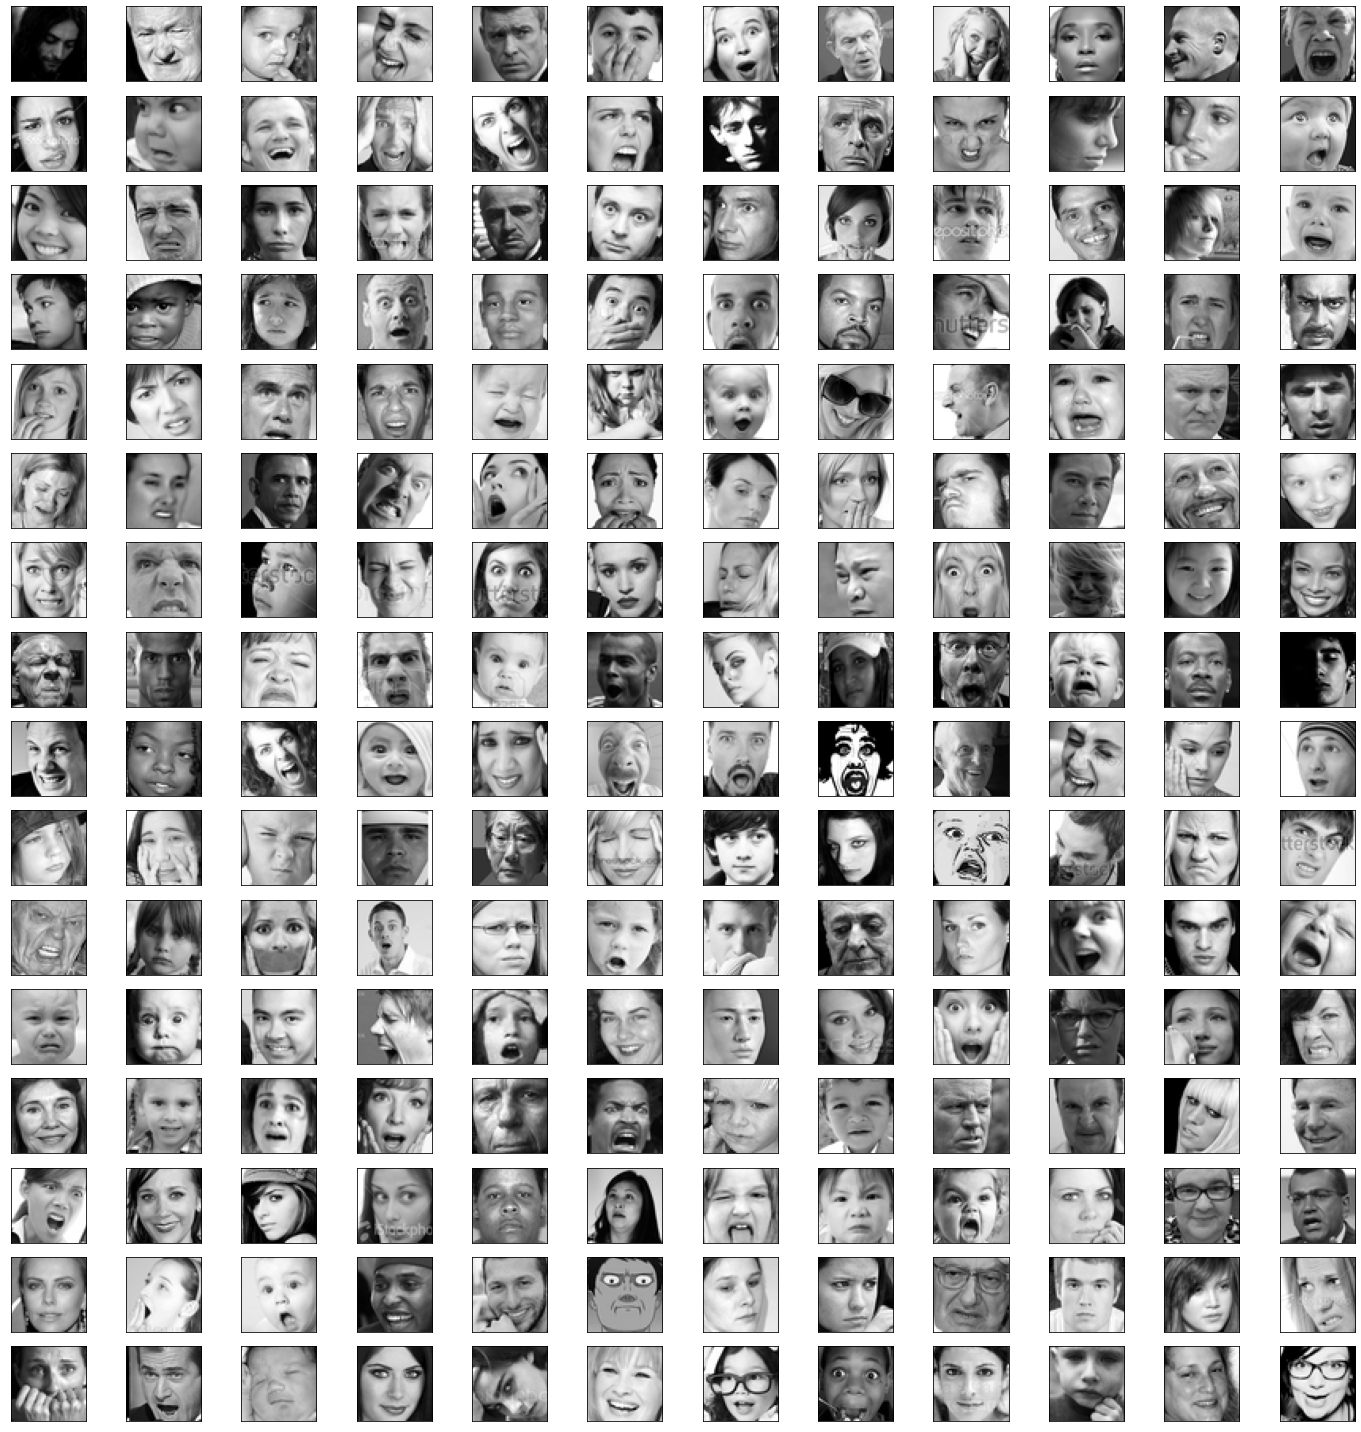

In [80]:
def overview(start, end, X):

    fig = plt.figure(figsize=(20,20))
    for i in range(start, end+1):
        input_img = np.array(df.iloc[i]).reshape(48,48).astype("int")
        #input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(16,12,i+1)
        ax.imshow(input_img, cmap=plt.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()
overview(0,191, df)

###frequency of target variable

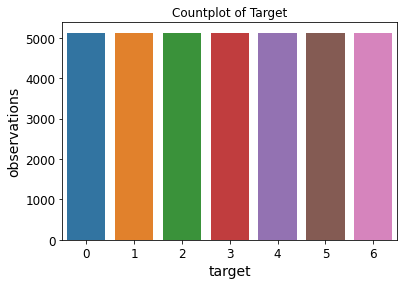

In [81]:
ax = sns.countplot(x="label", data=dataset)
plt.title('Countplot of Target')
plt.xlabel('target')
plt.ylabel('observations')
plt.show()

the target variable is well  balanced

### split the sataset

In [8]:
X = np.array(df).astype(np.float16)
y = np.array(dataset["label"].astype(np.int16))

X_train = X[:25000]
y_train = y[:25000]

X_val = X[25000:30441]
y_val = y[25000:30441]

X_test = X[30441:]
y_test = y[30441:]

### Create tensors

In [10]:
'''
Let's create a tensor from the numpy arrays
'''
x_train_tensor,x_val_tensor, x_test_tensor = map(torch.FloatTensor, (X_train, X_val, X_test))
y_train_tensor,y_val_tensor, y_test_tensor = map(torch.LongTensor, (y_train,y_val, y_test))

In [11]:
print('shape of x train: {}'.format(x_train_tensor.shape))

shape of x train: torch.Size([25000, 2304])


In [12]:
x_train_tensor = x_train_tensor.reshape(-1,1,48,48)
x_val_tensor = x_val_tensor.reshape(-1,1,48,48)
x_test_tensor = x_test_tensor.reshape(-1,1,48,48)

In [13]:
print('shape of x train: {}'.format(x_test_tensor.shape))

shape of x train: torch.Size([5441, 1, 48, 48])


### Create dataloader 

In [14]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 32 

train_ds = TensorDataset(x_train_tensor, y_train_tensor)
train_dl = DataLoader( train_ds, batch_size=batch_size, shuffle=True)

val_ds = TensorDataset(x_val_tensor, y_val_tensor)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)


test_ds = TensorDataset(x_test_tensor, y_test_tensor)
test_dl = DataLoader(test_ds, batch_size=batch_size)


## Construct the model

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=11, stride=1, padding=2)
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, stride=2, padding=0)
        self.relu2 = nn.ReLU()

        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        #convolution 3
        self.cnn3 = nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu3 = nn.ReLU(inplace=True)

        #Convolution 4
        self.cnn4 = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu4 = nn.ReLU(inplace=True)

        #max pool 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)


        # Fully connected 1
        self.fc1 = nn.Linear(256, 20)

        #Dropout
        self.drop1 = nn.Dropout(.5)

        # Fully connected 2
        self.fc2 = nn.Linear(20, 7)        

    def forward(self, x, to_print=False):
        # Set 1
        if to_print:
          print('INPUT',x.shape)
        out = self.cnn1(x)
        if to_print:
          print('CNN1',out.shape)
        out = self.relu1(out)
        out = self.maxpool1(out)
        if to_print:
          print('MAXPOOL1',out.shape)

        # Set 2
        out = self.cnn2(out)
        if to_print:
          print('CNN2',out.shape)

        out = self.relu2(out)

        out = self.maxpool2(out)
        if to_print:
          print("after the 2nd maxpool:{} ".format(out.shape))

        # Set 3
        out = self.cnn3(out)
        if to_print:
          print('CNN3',out.shape)

        out = self.relu3(out)

        if to_print:
          print("after the 2nd maxpool:{} ".format(out.shape))

        # Set 4
        out = self.cnn4(out)
        if to_print:
          print('CNN4',out.shape)

        out = self.relu4(out)

        out = self.maxpool3(out)
        if to_print:
          print("after the 3nd maxpool:{} ".format(out.shape))


        # Flatten
        out = out.view(out.size(0), -1)
        if to_print:
          print("after the flatten:{} ".format(out.shape))

        # fully connected nn 1
        out = self.fc1(out)
        if to_print:
          print("after the FCnn 1:{} ".format(out.shape))   

        #Drop 1     
        out = self.drop1(out)
        if to_print:
          print("after the dropout 1:{} ".format(out.shape))

        # fully connected nn 2
        out = self.fc2(out)
        if to_print:
          print('FINAL',out.shape)

        return out

### Training function

In [16]:


def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu",to_print=False):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad() # clear gradients for next train
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs,to_print)
            loss = loss_fn(output, targets)
            loss.backward() # backpropagation, compute gradients
            optimizer.step() # apply gradients
            training_loss += loss.data.item() * inputs.size(0)


            
            # print(training_loss,loss.data.item(),inputs.size(0))
            if to_print:
              break
        training_loss /= len(train_loader.dataset)
        if to_print:
          break




        with torch.no_grad():
          model.eval()
          num_correct = 0 
          num_examples = 0
          for batch in val_loader:
              inputs, targets = batch
              inputs = inputs.to(device)
              output = model(inputs)
              targets = targets.to(device)
              loss = loss_fn(output,targets) 
              valid_loss += loss.data.item() * inputs.size(0)
              correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
              num_correct += torch.sum(correct).item()
              num_examples += correct.shape[0]
          valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.4f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [17]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(),lr=0.001)
train(cnn, optimizer,torch.nn.CrossEntropyLoss(), train_dl,val_dl, epochs=5, to_print=True)

INPUT torch.Size([32, 1, 48, 48])
CNN1 torch.Size([32, 64, 42, 42])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


MAXPOOL1 torch.Size([32, 64, 20, 20])
CNN2 torch.Size([32, 192, 8, 8])
after the 2nd maxpool:torch.Size([32, 192, 3, 3]) 
CNN3 torch.Size([32, 384, 3, 3])
after the 2nd maxpool:torch.Size([32, 384, 3, 3]) 
CNN4 torch.Size([32, 256, 3, 3])
after the 3nd maxpool:torch.Size([32, 256, 1, 1]) 
after the flatten:torch.Size([32, 256]) 
after the FCnn 1:torch.Size([32, 20]) 
after the dropout 1:torch.Size([32, 20]) 
FINAL torch.Size([32, 7])


###train the model

In [35]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(),lr=0.001)
train(cnn, optimizer,torch.nn.CrossEntropyLoss(), train_dl,val_dl, epochs=20)

Epoch: 1, Training Loss: 1.9388, Validation Loss: 1.9363, accuracy = 0.1932
Epoch: 2, Training Loss: 1.8247, Validation Loss: 1.7890, accuracy = 0.2952
Epoch: 3, Training Loss: 1.7325, Validation Loss: 1.6822, accuracy = 0.3564
Epoch: 4, Training Loss: 1.6500, Validation Loss: 1.5684, accuracy = 0.4126
Epoch: 5, Training Loss: 1.5678, Validation Loss: 1.6566, accuracy = 0.3328
Epoch: 6, Training Loss: 1.5019, Validation Loss: 1.4161, accuracy = 0.4679
Epoch: 7, Training Loss: 1.4412, Validation Loss: 1.4433, accuracy = 0.4426
Epoch: 8, Training Loss: 1.3796, Validation Loss: 1.4034, accuracy = 0.4650
Epoch: 9, Training Loss: 1.3326, Validation Loss: 1.2746, accuracy = 0.5275
Epoch: 10, Training Loss: 1.2814, Validation Loss: 1.2965, accuracy = 0.5177
Epoch: 11, Training Loss: 1.2349, Validation Loss: 1.2620, accuracy = 0.5194
Epoch: 12, Training Loss: 1.1979, Validation Loss: 1.2313, accuracy = 0.5306
Epoch: 13, Training Loss: 1.1598, Validation Loss: 1.3509, accuracy = 0.4683
Epoch: 1

In [ ]:
cnn

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=7, bias=True)
)

##Find learning rate

In [1]:
def find_lr(model, loss_fn, optimizer, train_loader,init_value = 1e-8, final_value=1, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    training_loss = 0.0
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    model.train()
    for data in train_loader:
      # print('Batch number: {}'.format(batch_num))
      batch_num += 1
      inputs, targets = data
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      # print(loss)
      # Crash out if loss explodes

      if batch_num > 1 and loss > 10 * best_loss:
        print('Exploded current loss: {} best_loss: {}'.format(loss,best_loss))
        return log_lrs, losses

      # Record the best loss

      if loss < best_loss or batch_num == 1:
          best_loss = loss

      # Store the values
      losses.append(loss.item())
      log_lrs.append((lr))

      # Do the backward pass and optimize

      loss.backward()
      optimizer.step()

        # Update the lr for the next step and store

      lr *= update_step
      optimizer.param_groups[0]["lr"] = lr
    
    print(len(log_lrs),len(losses))
    if len(log_lrs) > 20:
      print(len(log_lrs),len(losses))
      return log_lrs[10:-5], losses[10:-5]
    else:
      return log_lrs, losses


In [34]:
#load the data again just to be sure what we are using
batch_size = 128


optimizer = optim.Adam(cnn.parameters(), lr=0.001)
(lrs, losses) = find_lr(cnn, torch.nn.CrossEntropyLoss(), optimizer, train_dl,device='cpu')


Exploded current loss: 4.644949913024902 best_loss: 0.4048317074775696


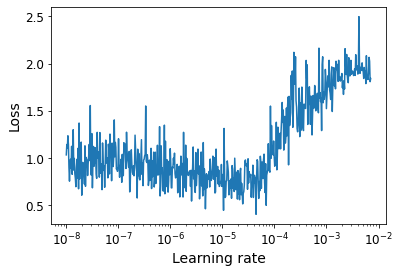

In [35]:
plt.plot(lrs, losses,)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

##Test the model

###Single instances

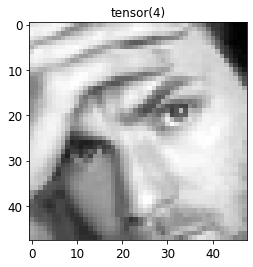

tensor([[ 1.2117, -0.8613,  1.7649, -1.1231,  0.7279, -0.6148, -0.6958]])
tensor(1.7649)
tensor(2)


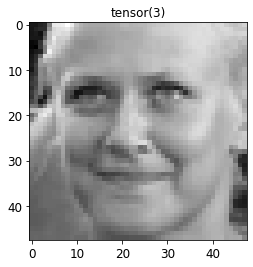

tensor([[ 0.4216, -0.3720, -0.5550,  2.8335,  0.3030, -2.5495,  0.1756]])
tensor(2.8335)
tensor(3)


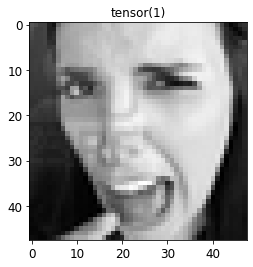

tensor([[ 1.6401,  8.1776, -1.0911, -2.0478, -2.2604, -2.6563, -3.0576]])
tensor(8.1776)
tensor(1)


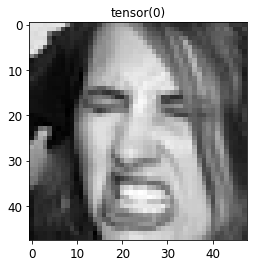

tensor([[ 1.7395, -2.4046,  1.1867, -0.3913,  0.3027, -1.2870,  0.8756]])
tensor(1.7395)
tensor(0)


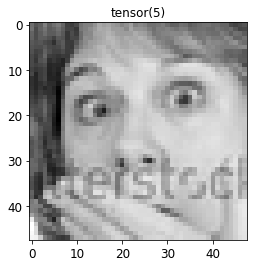

tensor([[-0.6750, -0.2416,  1.2930,  1.0770, -1.0074,  1.6343, -0.4981]])
tensor(1.6343)
tensor(5)


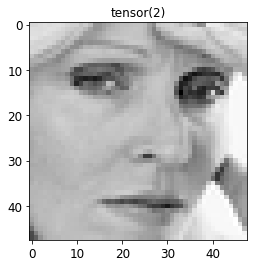

tensor([[ 0.9789,  0.5602,  0.5735, -0.9655,  0.2404, -0.6194, -0.0814]])
tensor(0.9789)
tensor(0)


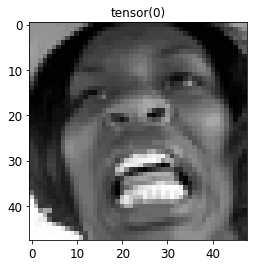

tensor([[ 1.8399, -1.9005,  0.8758,  1.4282, -0.0813, -1.3660, -0.4903]])
tensor(1.8399)
tensor(0)


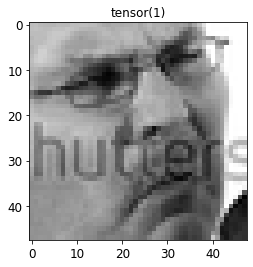

tensor([[ 2.5700,  7.1100, -1.2389, -0.5106, -0.7654, -4.6351, -2.9207]])
tensor(7.1100)
tensor(1)


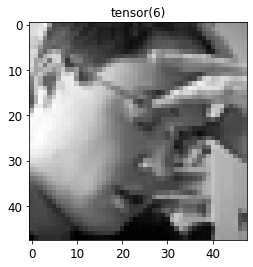

tensor([[ 0.0524, -4.6784,  1.7921, -1.6548,  1.6283,  0.7211,  1.8851]])
tensor(1.8851)
tensor(6)


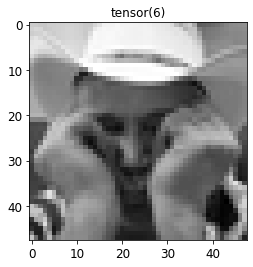

tensor([[ 1.7150, -4.9927,  0.3202, -1.1486,  1.6825, -1.0922,  2.9406]])
tensor(2.9406)
tensor(6)


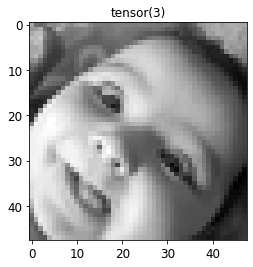

tensor([[ 0.6354, -4.2982,  1.8630, -0.1968,  1.6698, -1.8272,  1.4160]])
tensor(1.8630)
tensor(2)


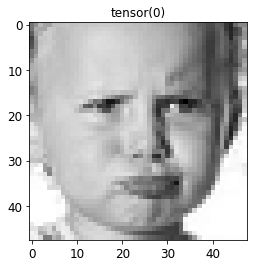

tensor([[ 4.1684, -0.2273,  1.3786, -3.0358,  1.3087, -4.1558,  0.2401]])
tensor(4.1684)
tensor(0)


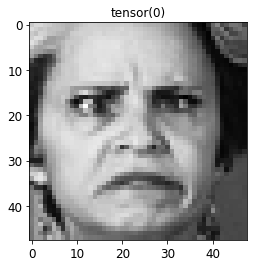

tensor([[ 3.8944, -2.1790,  2.0086, -5.0318,  1.7107, -2.2164,  0.7334]])
tensor(3.8944)
tensor(0)


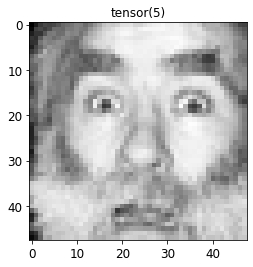

tensor([[ 0.2829, -0.2942,  1.0358, -0.7624, -0.3164,  0.6904,  0.1742]])
tensor(1.0358)
tensor(2)


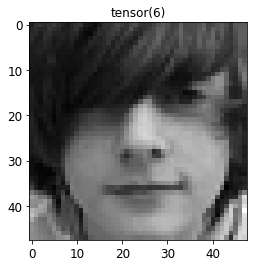

tensor([[ 0.6188, -4.0521,  0.6460, -0.9312,  1.3807, -0.6974,  2.8917]])
tensor(2.8917)
tensor(6)


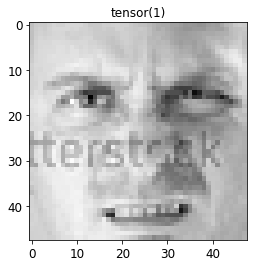

tensor([[ 1.2479,  5.4368,  0.0521, -1.0331, -1.8667, -1.4452, -2.8087]])
tensor(5.4368)
tensor(1)


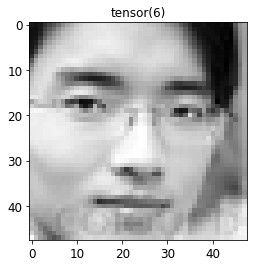

tensor([[-0.3456, -6.0581,  1.1165,  0.3739,  2.4192, -1.7791,  3.7880]])
tensor(3.7880)
tensor(6)


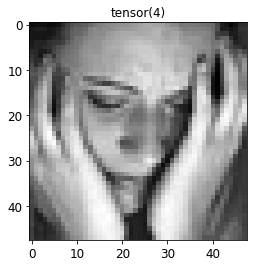

tensor([[ 0.7810, -5.1885,  1.8820, -2.2623,  3.4271, -1.2705,  2.1944]])
tensor(3.4271)
tensor(4)


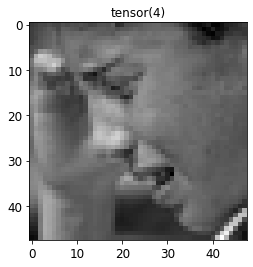

tensor([[ 1.0560, -2.0157,  1.3128, -1.0774,  0.9740,  0.0800,  0.2566]])
tensor(1.3128)
tensor(2)


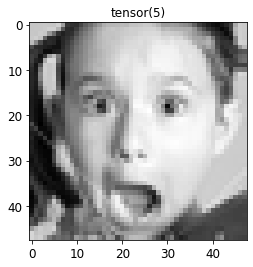

tensor([[-0.5144, -2.7481,  3.2723, -2.6989, -1.2686,  5.9326, -0.8510]])
tensor(5.9326)
tensor(5)


In [36]:
with torch.no_grad():
  cnn.eval()
  for i in range(20):
    plt.imshow(x_test_tensor[i].reshape((48,48)), cmap="gray")
    plt.title(y_test_tensor[i])
    plt.show()
    print(cnn(x_test_tensor[i].reshape(-1,1,48,48)))
    print(cnn(x_test_tensor[i].reshape(-1,1,48,48)).max())
    print(cnn(x_test_tensor[i].reshape(-1,1,48,48)).argmax())

###Test on test set

In [37]:
# Test the model
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dl:
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Save the model and plot
torch.save(cnn.state_dict(), home + 'conv_net_model.ckpt')

Test Accuracy of the model on the 10000 test images: 59.08840286712002 %


get predictions:

In [38]:
@torch.no_grad()
def get_all_preds(model, dataloader):
    all_preds = torch.tensor([])
    for batch in dataloader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [39]:
with torch.no_grad():
    train_preds = get_all_preds(cnn, test_dl)

creating confusion matrix

In [40]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_dl.dataset.tensors[1], train_preds.argmax(dim=1))
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[467,  35, 109,  37,  57,   9, 101],
       [  0, 775,   0,   0,   0,   0,   0],
       [121,  14, 377,  36,  74,  54,  67],
       [ 87,  16,  60, 484,  33,  10,  79],
       [168,  18, 169,  49, 205,  12, 167],
       [ 26,   3, 150,  25,  12, 483,  42],
       [120,  13,  96,  80,  64,  13, 424]])

##Load the saved model

In [22]:
model = CNN()
model.load_state_dict(torch.load( home + "conv_net_model.ckpt"))
model.eval()

CNN(
  (cnn1): Conv2d(1, 64, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(64, 192, kernel_size=(5, 5), stride=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace=True)
  (cnn4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU(inplace=True)
  (maxpool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=20, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=20, out_features=7, bias=True)
)